In [339]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c, h, k_B, M_sun, L_sun
from matplotlib.patches import Rectangle
from tqdm import tqdm
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from lmfit import Model, Parameters
from itertools import compress, zip_longest, permutations, combinations, chain
utils.rcparams()

In [3]:
herschel = utils.full_loader('Herschel')
vla = utils.full_loader('VLA_COSMOS2020_05')

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def bb(nu, t):
    return (nu**3)*(1/(np.exp((h.value*nu)/(k_B.value*t)) - 1))

def mbb(nu_rest, log_norm, t, beta):
    norm = 10**log_norm
    return norm*(nu_rest**beta)*bb(nu_rest, t)

In [528]:
class Object:

    def __init__(self, name, ra_deg, dec_deg):
        self.id = name
        self.ra = ra_deg
        self.dec = dec_deg


class Source(Object):

    def __init__(self, name, ra, dec, wavelengths_obs_um, fluxes, flux_errors):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.wavelengths_obs_um = wavelengths_obs_um
        self.fluxes = fluxes
        self.flux_errors = flux_errors


class Counterpart(Object):

    def __init__(self, name, ra, dec, fluxes, redshift, stellar_mass):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.fluxes = fluxes
        self.redshift = redshift
        self.stellar_mass = stellar_mass

    @property
    def luminosity_distance(self):
        return cosmo.luminosity_distance(z = self.redshift)

    def number_density(self, counterparts, area):
        return np.sum([counterpart.fluxes > self.fluxes for counterpart in counterparts])/area

    def separation(self, other):
        return np.sqrt(((self.ra - other.ra)**2)+((self.dec - other.dec)**2))*3600

    def s_value(self, source, counterparts, area):
        r = self.separation(source)
        n = self.number_density(counterparts, area)
        s = (r**2)*n
        return s


class Pair:

    def __init__(self, source, counterpart, r, s, p, fit_sed=True):
        self.source = source
        self.counterpart = counterpart
        self.r = r
        self.s = s
        self.p = p

        self.t_cmb = 2.725*(1+self.counterpart.redshift)
        self.source.wavelengths_obs_m = self.source.wavelengths_obs_um*1e-6
        self.source.wavelengths_rest_m = self.source.wavelengths_obs_m/(1+self.counterpart.redshift)
        self.source.nu_rest = c.value/self.source.wavelengths_rest_m

        if fit_sed:

            if np.isnan(self.counterpart.redshift):
                self.log_norm = np.nan
                self.t = np.nan
                self.beta = np.nan
            else:
                mbb_model = Model(mbb)
                params = Parameters()
                params.add_many(('log_norm', -60, True, -65, -55),
                                ('t', 20, True, self.t_cmb, 50),
                                ('beta', 2, True, 1, 4))
                mbb_fit = mbb_model.fit(self.source.fluxes, params, nu_rest=self.source.nu_rest, weights=1/self.source.flux_errors)

                self.log_norm = mbb_fit.params['log_norm'].value
                self.t = mbb_fit.params['t'].value
                self.beta = mbb_fit.params['beta'].value

    def sed(self, nu_rest):
        return mbb(nu_rest, self.log_norm, self.t, self.beta)*u.Jy

    def fir_luminosity(self, lam_um_rest_low=8, lam_um_rest_high=1000):
        lam_low_um_rest, lam_high_um_rest = lam_um_rest_low*u.micron, lam_um_rest_high*u.micron
        wave_range_rest_um = np.linspace(1, 5000, 100000) * u.micron
        wave_range_rest_m = wave_range_rest_um.to(u.m)
        freq_range_rest = c / wave_range_rest_m
        idx = np.where((wave_range_rest_um >= lam_low_um_rest) & (wave_range_rest_um <= lam_high_um_rest))

        diff_freq = np.diff(freq_range_rest)
        diff_freq = np.append(diff_freq, diff_freq[-1])

        sed_obs_integral = self.sed(freq_range_rest[idx].value)
        sed_rest_integral = sed_obs_integral/(1+self.counterpart.redshift)
        integral = np.sum(-sed_rest_integral*diff_freq[idx])

        d_L = cosmo.luminosity_distance(z=self.counterpart.redshift).to(u.m)
        l_watt = (4 * np.pi * (d_L ** 2) * integral).to(u.Watt)
        l_sun = l_watt.to(u.L_sun)
        return l_sun

    def sfr(self):
        # From Murphy+2011
        l_sun = self.fir_luminosity()
        l_cgs = l_sun.to(u.erg/u.s)
        constant = 3.88e-44*(u.M_sun/u.yr)/(u.erg/u.s)
        sfr = constant*l_cgs
        return sfr


In [529]:
source_params = {'data': herschel,
                 'name': 'id_her',
                 'ra': 'RA_her',
                 'dec': 'Dec_her',
                 'wavelengths_obs_um': np.array([250,350,500]),
                 'fluxes': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500'],
                 'flux_errors': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500']}

counterpart_params = {'data': vla,
                      'name': 'id_cos',
                      'ra': 'RA_cos',
                      'dec': 'Dec_cos',
                      'fluxes': ['total_int_flux'],
                      'redshift': 'lp_zPDF',
                      'stellar_mass': 'lp_mass_med'}


def create_sources_and_counterparts(source_params, counterpart_params):

    source_catalogue = []
    for obj in tqdm(range(len(source_params['data'])), desc='Creating Sources'):
        name = source_params['data'][source_params['name']][obj]
        ra = source_params['data'][source_params['ra']][obj]
        dec = source_params['data'][source_params['dec']][obj]
        wavelengths_obs_um = source_params['wavelengths_obs_um']
        fluxes = np.array(source_params['data'][source_params['fluxes']].iloc[obj])
        flux_errors = np.array(source_params['data'][source_params['flux_errors']].iloc[obj])
        source = Source(name, ra, dec, wavelengths_obs_um, fluxes, flux_errors)
        source_catalogue.append(source)

    counterpart_catalogue = []
    for obj in tqdm(range(len(counterpart_params['data'])), desc='Creating Counterparts'):
        name = counterpart_params['data'][counterpart_params['name']][obj]
        ra = counterpart_params['data'][counterpart_params['ra']][obj]
        dec = counterpart_params['data'][counterpart_params['dec']][obj]
        fluxes = np.array(counterpart_params['data'][counterpart_params['fluxes']].iloc[obj])
        redshift = counterpart_params['data'][counterpart_params['redshift']][obj]
        stellar_mass = counterpart_params['data'][counterpart_params['stellar_mass']][obj]
        counterpart = Counterpart(name, ra, dec, fluxes, redshift, stellar_mass)
        counterpart_catalogue.append(counterpart)

    return source_catalogue, counterpart_catalogue


In [530]:
herschel_objects, vla_objects = create_sources_and_counterparts(source_params, counterpart_params)

Creating Counterparts: 100%|██████████| 10830/10830 [00:01<00:00, 9591.71it/s]


In [531]:
# Create a set of N random sources
def random_sources(n, ra_min, ra_max, dec_min, dec_max):
    sources_rand = []
    for it in range(n):
        ra_random, dec_random = np.random.uniform(ra_min, ra_max), np.random.uniform(dec_min, dec_max)
        random_source = Source(it, ra_random, dec_random, np.array([0]), np.array([0]), np.array([0]))
        sources_rand.append(random_source)
    return sources_rand


class Survey:

    def __init__(self, sources, counterparts):

        # Input sources and counterparts
        self.sources_all = sources
        self.counterparts_all = counterparts
        print('Input Number of Sources = {}'.format(len(self.sources_all)))
        print('Input Number of Counterparts = {}'.format(len(self.counterparts_all)))

        # Define the overlapping survey area
        sources_ra = [self.sources_all[obj].ra for obj in range(len(self.sources_all))]
        sources_dec = [self.sources_all[obj].dec for obj in range(len(self.sources_all))]
        counterparts_ra = [self.counterparts_all[obj].ra for obj in range(len(self.counterparts_all))]
        counterparts_dec = [self.counterparts_all[obj].dec for obj in range(len(self.counterparts_all))]
        self.ra_min, self.ra_max = max(min(sources_ra),min(counterparts_ra)), min(max(sources_ra),max(counterparts_ra))
        self.dec_min, self.dec_max = max(min(sources_dec),min(counterparts_dec)), min(max(sources_dec),max(counterparts_dec))
        self.area_deg = (abs(self.ra_max - self.ra_min)) * (abs(self.dec_max - self.dec_min))
        self.area_arcsec = (np.sqrt(self.area_deg)*3600)**2

        # Reduce sources and counterparts to overlapping region
        self.sources = [obj for obj in self.sources_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        self.counterparts = [obj for obj in self.counterparts_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        print('Overlapping Number of Sources = {} ({:.2f}%)'.format(len(self.sources), (len(self.sources)/len(self.sources_all))*100))
        print('Overlapping Number of Counterparts = {} ({:.2f}%)'.format(len(self.counterparts), (len(self.counterparts)/len(self.counterparts_all))*100))

    # Get random sources
    def get_random_sources(self, n):
        sources_rand = random_sources(n, self.ra_min, self.ra_max, self.dec_min, self.dec_max)
        return sources_rand

    def get_s_values(self, r_max, n=10000, random_sources=False):
        if random_sources:
            sources = self.get_random_sources(n)
        else:
            sources = self.sources

        min_s_values = []
        for source in tqdm(sources, desc='Calculating S Values'):
            counterpart_s_values = []
            for counterpart in self.counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_values.append(min_s)
        N = len(sources)
        return min_s_values, N

    # Get S distribution
    def get_s_dist(self, r_max, n=10000, n_bins=100, random_sources=False):
        min_s_values, N = self.get_s_values(r_max, n, random_sources)
        min_s_values_finite = np.array([s for s in min_s_values if np.isfinite(s)])
        s_hist, bin_edges = np.histogram(min_s_values_finite, bins=np.logspace(-8,0,n_bins))
        s_hist_norm = s_hist/N
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

        s_distribution = {'N': N,
                          'dist': s_hist,
                          'dist_norm': s_hist_norm,
                          'bin_edges': bin_edges,
                          'bin_centers': bin_centers,
                          'S_values': min_s_values}

        return s_distribution

    # Get IDs
    def get_matches(self, r_max, n=10000, n_bins=100):
        s_distribution_random = self.get_s_dist(r_max, n, n_bins, random_sources=True)

        pairs = []
        for source in tqdm(self.sources, desc='Calculating P Values'):
            for counterpart in self.counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    s_idx = np.argmin(abs(s-s_distribution_random['bin_centers']))
                    p = np.trapz(s_distribution_random['dist_norm'][:s_idx])
                    if p < 1/s_distribution_random['N']:
                        p = 1/s_distribution_random['N']
                    pair = Pair(source, counterpart, r, s, p)
                    pairs.append(pair)

        return pairs

In [532]:
cosmos = Survey(herschel_objects, vla_objects)

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)


In [533]:
print('The overlapping region covers RA: {:.2f} - {:.2f} and Dec {:.2f} - {:.2f}'.format(cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max))
print('The total area of the overlapping region = {:.2f} square degrees'.format(cosmos.area_deg))

The overlapping region covers RA: 149.29 - 150.95 and Dec 1.45 - 3.04
The total area of the overlapping region = 2.64 square degrees


In [534]:
herschel_vla = cosmos.get_matches(10)

Calculating P Values: 100%|██████████| 7230/7230 [01:31<00:00, 79.24it/s] 


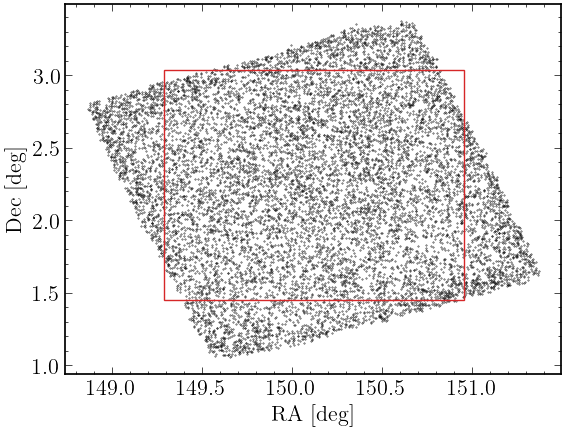

In [547]:
herschel_ras = [herschel_objects[it].ra for it in range(len(herschel_objects))]
herschel_decs = [herschel_objects[it].dec for it in range(len(herschel_objects))]

fig, ax = plt.subplots()
ax.scatter(herschel_ras, herschel_decs, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='tab:red', facecolor='none'))
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.savefig(utils.ROOT+'/figures/sky_map.pdf', dpi=1000)
plt.show()

In [663]:
herschel_vla_large_r = cosmos.get_matches(30)

Calculating P Values: 100%|██████████| 7230/7230 [02:22<00:00, 50.83it/s]


In [664]:
all_offsets = [herschel_vla_large_r[it].r for it in range(len(herschel_vla_large_r))]

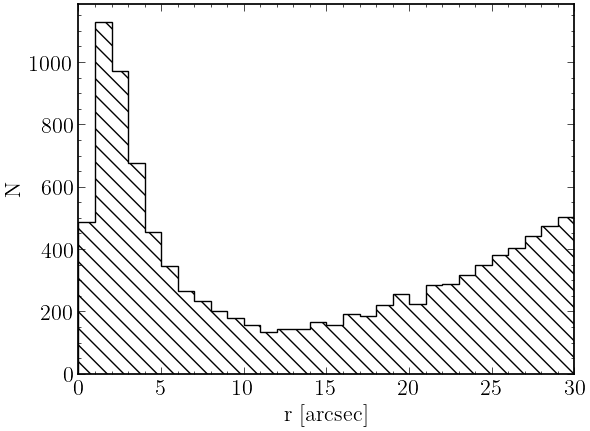

In [665]:
fig, ax = plt.subplots()
ax.hist(all_offsets, bins=30, range=(0,30), histtype='step', hatch=r'\\')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,30)
plt.show()

In [666]:
r_range = np.linspace(0,30,30)

n_unrelated = len(cosmos.counterparts)-(len(cosmos.sources)*0.001)
n_unrelated_density = n_unrelated/cosmos.area_arcsec
print(n_unrelated)
print(n_unrelated_density)

10818.77
0.000316378931526736


[0.0, 7.690281524157703, 30.76112609663081, 69.21253371741933, 123.04450438652324, 192.25703810394256, 276.85013486967733, 376.8237946837274, 492.178017546093, 622.9128034567741, 769.0281524157703, 930.5240644230821, 1107.4005394787093, 1299.6575775826518, 1507.2951787349095, 1730.313342935483, 1968.712070184372, 2222.4913604815765, 2491.6512138270964, 2776.1916302209306, 3076.112609663081, 3391.4141521535466, 3722.0962576923284, 4068.158926279425, 4429.602157914837, 4806.425952598564, 5198.630310330607, 5606.215231110965, 6029.180714939638, 6467.526761816627]
[  7.69028152  23.07084457  38.45140762  53.83197067  69.21253372
  84.59309677  99.97365981 115.35422286 130.73478591 146.11534896
 161.49591201 176.87647506 192.2570381  207.63760115 223.0181642
 238.39872725 253.7792903  269.15985335 284.54041639 299.92097944
 315.30154249 330.68210554 346.06266859 361.44323164 376.82379468
 392.20435773 407.58492078 422.96548383 438.34604688]


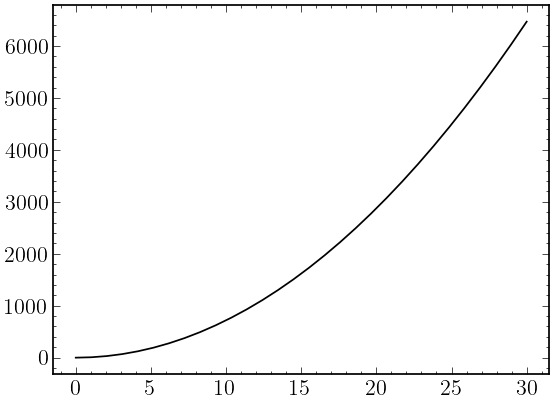

In [667]:
r_unrelated = [n_unrelated_density*(len(cosmos.sources)*np.pi*(r**2)) for r in r_range]
print(r_unrelated)
print(np.diff(r_unrelated))

fig, ax = plt.subplots()
ax.plot(r_range, r_unrelated)
plt.show()

In [668]:
herschel_ds, N_herschel = cosmos.get_s_values(10)

Calculating S Values: 100%|██████████| 7230/7230 [01:10<00:00, 102.97it/s]


In [669]:
random_ds, N_random = cosmos.get_s_values(10, n=50000, random_sources=True)

Calculating S Values: 100%|██████████| 50000/50000 [05:54<00:00, 140.91it/s]


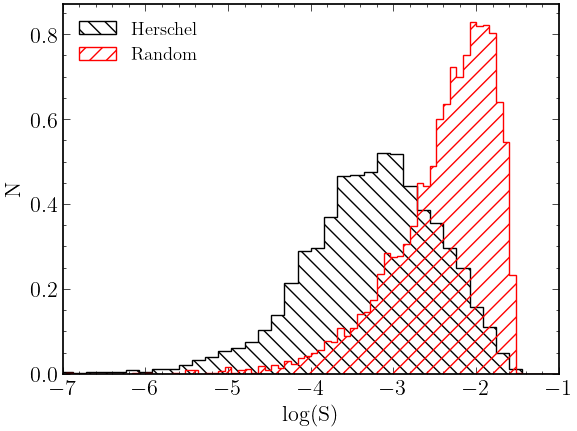

In [755]:
n_bins_herschel = 50
n_bins_random = 100
logs_range = (-8,0)

fig, ax = plt.subplots()
ax.hist(np.log10(herschel_ds), bins=n_bins_herschel, range=logs_range, histtype='step', hatch=r'\\', label=r'Herschel', density=True)
ax.hist(np.log10(random_ds), bins=n_bins_random, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.set_xlim(-7,-1)
ax.legend(loc='upper left')
plt.show()

In [567]:
robust_idx = [herschel_vla[it].p < 0.05 for it in range(len(herschel_vla))]
tentative_idx = [0.05 < herschel_vla[it].p < 0.1 for it in range(len(herschel_vla))]

In [568]:
herschel_vla_robust = list(compress(herschel_vla, robust_idx))
herschel_vla_tentative = list(compress(herschel_vla, tentative_idx))

In [569]:
herschel_vla_robust_ids, herschel_vla_robust_counts = np.unique([herschel_vla_robust[it].source.id for it in range(len(herschel_vla_robust))], return_counts=True)
herschel_vla_robust_sorted = sorted(herschel_vla_robust, key = lambda x: (x.source.id, x.p))
herschell_vla_robust_lists = [[val for i, val in enumerate(herschel_vla_robust_sorted) if val.source.id == idx] for idx in herschel_vla_robust_ids]
herschell_vla_robust_array = np.array(list(zip_longest(*herschell_vla_robust_lists, fillvalue=np.nan))).T
herschel_vla_robust_singles = herschell_vla_robust_array[pd.isna(herschell_vla_robust_array[:, 1])][:,0]
herschel_vla_robust_multiples = herschell_vla_robust_array[~pd.isna(herschell_vla_robust_array[:, 1])]

In [1054]:
herschel_vla_robust_singles_fluxes = [pair.source.fluxes[0] for pair in herschel_vla_robust_singles]
herschel_vla_robust_multiples_fluxes = [pair.source.fluxes[0] for pair in herschel_vla_robust_multiples[:,0]]
herschel_fluxes = [cosmos.sources[it].fluxes[0] for it in range(len(cosmos.sources))]

In [1055]:
flux_range = np.logspace(-2.5, 0, 30)

single_fluxes, flux_bins = np.histogram(herschel_vla_robust_singles_fluxes, bins=flux_range)
multiple_fluxes, _ = np.histogram(herschel_vla_robust_multiples_fluxes, bins=flux_range)
combined_fluxes = single_fluxes+multiple_fluxes
all_fluxes, _ = np.histogram(herschel_fluxes, bins=flux_range)
flux_bin_centers = (flux_bins[:-1] + flux_bins[1:])/2

single_fluxes_err = np.sqrt(single_fluxes)
multiple_fluxes_err = np.sqrt(multiple_fluxes)
combined_fluxes_err = np.sqrt(combined_fluxes)
all_fluxes_err = np.sqrt(all_fluxes)

all_id_frac = combined_fluxes/all_fluxes
single_id_frac = single_fluxes/all_fluxes
multiple_id_frac = multiple_fluxes/all_fluxes

all_id_frac_err = np.sqrt(((combined_fluxes_err/combined_fluxes)**2) + ((all_fluxes_err/all_fluxes)**2))

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_5550/96347999.py:14: RuntimeWarning: invalid value encountered in divide
  all_id_frac = combined_fluxes/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_5550/96347999.py:15: RuntimeWarning: invalid value encountered in divide
  single_id_frac = single_fluxes/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_5550/96347999.py:16: RuntimeWarning: invalid value encountered in divide
  multiple_id_frac = multiple_fluxes/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_5550/96347999.py:18: RuntimeWarning: invalid value encountered in divide
  all_id_frac_err = np.sqrt(((combined_fluxes_err/combined_fluxes)**2) + ((all_fluxes_err/all_fluxes)**2))


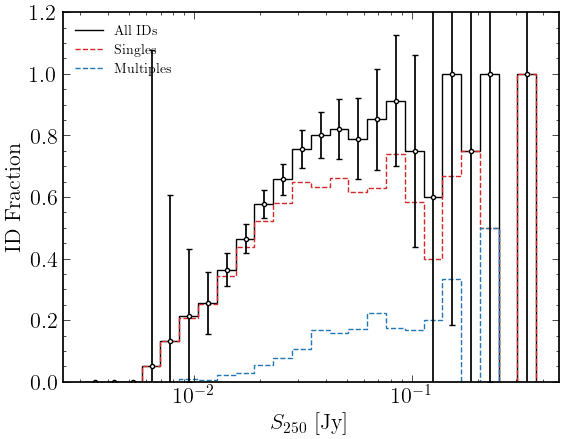

In [1056]:
fig, ax = plt.subplots()
ax.stairs(all_id_frac, flux_bins, color='k', label=r'All IDs')
ax.errorbar(flux_bin_centers, all_id_frac, yerr=all_id_frac_err, fmt='.', c='k')
ax.stairs(single_id_frac, flux_bins, color='tab:red', linestyle='--', label=r'Singles')
ax.stairs(multiple_id_frac, flux_bins, color='tab:blue', linestyle='--', label=r'Multiples')
ax.set_xlabel(r'$S_{250}$ [Jy]')
ax.set_ylabel(r'ID Fraction')
ax.set_ylim(0,1.2)
ax.semilogx()
ax.legend(loc='upper left', fontsize=10)
plt.show()

In [1032]:
class Group:

    def __init__(self, pairs):
        self.pairs = pairs

    def counterpart_counterpart_z_difference(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = [abs(self.pairs[it[0]].counterpart.redshift - self.pairs[it[1]].counterpart.redshift) for it in index_list]
        return z_diff

    def select_close_counterpart_pairs(self, z_max=0.2):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = self.counterpart_counterpart_z_difference()
        close_index = [idx for idx, z in zip(index_list, z_diff) if z <= z_max]
        close_index_flat = list(set([item for sublist in close_index for item in sublist]))
        close_pairs = [self.pairs[idx] for idx in close_index_flat]
        return close_pairs

    def counterpart_source_separations(self):
        separations_arcsec = [pair.r for pair in self.pairs]
        return separations_arcsec

    def counterpart_counterpart_separations(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        separations_arcsec = [self.pairs[it[0]].counterpart.separation(self.pairs[it[1]].counterpart) for it in index_list]
        return separations_arcsec

    def counterpart_counterpart_distance(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        av_z = [(self.pairs[it[0]].counterpart.redshift+self.pairs[it[1]].counterpart.redshift)/2 for it in index_list]
        separations_arcsec = self.counterpart_counterpart_separations()*u.arcsec
        try:
            d_A = cosmo.angular_diameter_distance(av_z)
        except:
            d_A = np.nan*u.Mpc

        distance_kpc = (separations_arcsec*d_A).to(u.kpc, u.dimensionless_angles())
        return distance_kpc

    def counterpart_counterpart_flux_difference(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        flux_diff = [abs(self.pairs[it[0]].counterpart.fluxes.item() - self.pairs[it[1]].counterpart.fluxes.item()) for it in index_list]
        return flux_diff



In [1033]:
herschel_vla_robust_singles_list = [[pair] for pair in herschel_vla_robust_singles]
herschel_vla_robust_multiples_list = [herschel_vla_robust_multiples[it][~pd.isnull(herschel_vla_robust_multiples[it])].tolist() for it in range(len(herschel_vla_robust_multiples))]

In [1034]:
herschel_vla_singles = [Group(pairs) for pairs in herschel_vla_robust_singles_list]
herschel_vla_multiples = [Group(pairs) for pairs in herschel_vla_robust_multiples_list]

In [1035]:
herschel_vla_close_multiples_list = [herschel_vla_multiples[it].select_close_counterpart_pairs(z_max=0.2) for it in range(len(herschel_vla_multiples))]
herschel_vla_close_multiples = [Group(pairs) for pairs in herschel_vla_close_multiples_list]

#### Source-Counterpart Offsets

In [634]:
# I think the normalization is (r/sigma^2) but sigma is constrained from the width anyway
def rayleigh(r, A, sigma):
    return A*r*np.exp(-(r**2)/(2*(sigma**2)))

herschel_vla_sc_offset_singles_lists = [herschel_vla_singles[it].counterpart_source_separations() for it in range(len(herschel_vla_singles))]
herschel_vla_sc_offset_multiples_lists = [herschel_vla_multiples[it].counterpart_source_separations() for it in range(len(herschel_vla_multiples))]

herschel_vla_sc_offset_singles = list(chain.from_iterable(herschel_vla_sc_offset_singles_lists))
herschel_vla_sc_offset_multiples = list(chain.from_iterable(herschel_vla_sc_offset_multiples_lists))

In [635]:
herschel_vla_sc_offset_all = herschel_vla_sc_offset_singles + herschel_vla_sc_offset_multiples

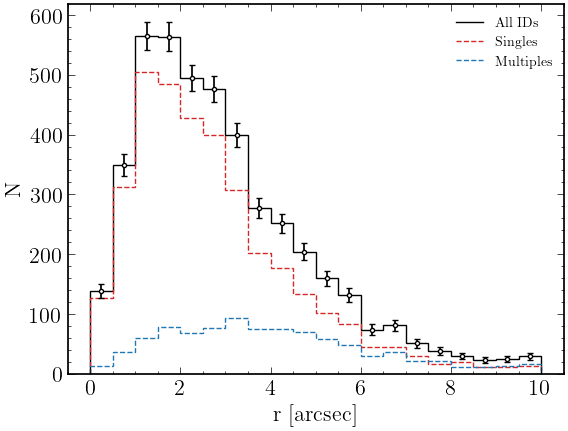

In [636]:
all_sc_hist, r_bins = np.histogram(herschel_vla_sc_offset_all, bins=20, range=(0,10))
single_sc_hist, _ = np.histogram(herschel_vla_sc_offset_singles, bins=20, range=(0,10))
multiple_sc_hist, _ = np.histogram(herschel_vla_sc_offset_multiples, bins=20, range=(0,10))
all_sc_hist_err = np.sqrt(all_sc_hist)
single_sc_hist_err = np.sqrt(single_sc_hist)
multiple_sc_hist_err = np.sqrt(multiple_sc_hist)
r_bin_centers = (r_bins[:-1] + r_bins[1:])/2

fig, ax = plt.subplots()
ax.stairs(all_sc_hist, r_bins, color='k', label='All IDs')
ax.stairs(single_sc_hist, r_bins, linestyle='--', color='tab:red', label='Singles')
ax.stairs(multiple_sc_hist, r_bins, linestyle='--', color='tab:blue', label='Multiples')
ax.errorbar(r_bin_centers, all_sc_hist, yerr=all_sc_hist_err, fmt='.', c='k')
#ax.errorbar(r_bin_centers, single_sc_hist, yerr=single_sc_hist_err, fmt='.', c='tab:red')
#ax.errorbar(r_bin_centers, multiple_sc_hist, yerr=multiple_sc_hist_err, fmt='.', c='tab:blue')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

#### Counterpart-Counterpart Redshift Differences

In [1044]:
herschel_vla_cc_zdiff_multiples_lists = [herschel_vla_multiples[it].counterpart_counterpart_z_difference() for it in range(len(herschel_vla_multiples))]
herschel_vla_cc_zdiff_multiples = list(chain.from_iterable(herschel_vla_cc_zdiff_multiples_lists))

In [1045]:
herschel_vla_cc_zdiff_close_multiples_lists = [herschel_vla_close_multiples[it].counterpart_counterpart_z_difference() for it in range(len(herschel_vla_close_multiples))]
herschel_vla_cc_zdiff_close_multiples = list(chain.from_iterable(herschel_vla_cc_zdiff_close_multiples_lists))

In [1046]:
# A random selection of radio sources as a comparison

N = 1000000
random_z_differences = []

for _ in range(N):
    rand_obj_1, rand_obj_2 = random.sample(vla_objects, 2)
    rand_z_diff = abs(rand_obj_1.redshift - rand_obj_2.redshift)
    if rand_z_diff > 0:
        random_z_differences.append(rand_z_diff)

In [1047]:
n_bins = 20
n_bins_random = 100
r_range = (0,4)
weights = np.full_like(random_z_differences, (n_bins_random/n_bins)*len(herschel_vla_cc_zdiff_multiples)/N)

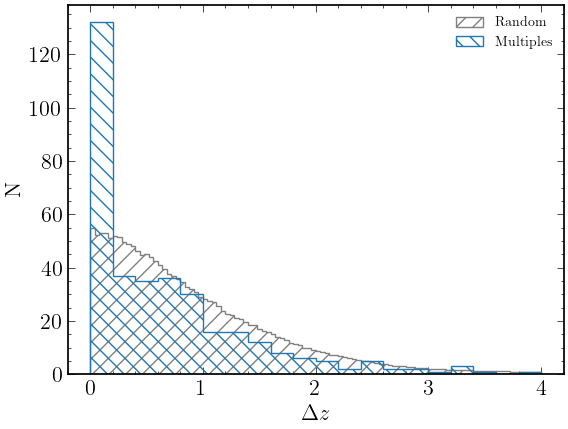

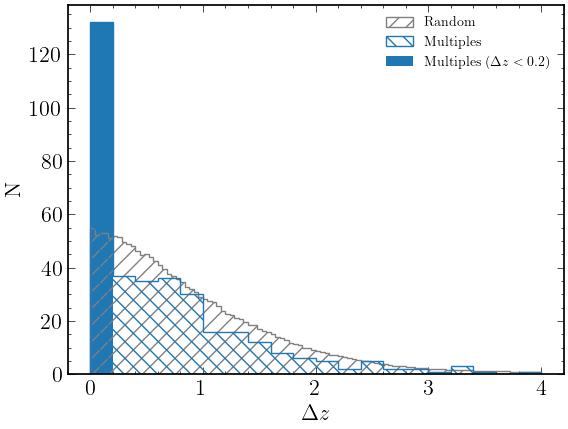

In [1048]:
fig, ax = plt.subplots()
ax.hist(random_z_differences, bins=n_bins_random, range=r_range, histtype='step', hatch=r'//', color='grey', label=r'Random', weights=weights)
ax.hist(herschel_vla_cc_zdiff_multiples, bins=n_bins, range=r_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.set_xlabel(r'$\Delta z$')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

fig, ax = plt.subplots()
ax.hist(random_z_differences, bins=n_bins_random, range=r_range, histtype='step', hatch=r'//', color='grey', label=r'Random', weights=weights)
ax.hist(herschel_vla_cc_zdiff_multiples, bins=n_bins, range=r_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.hist(herschel_vla_cc_zdiff_close_multiples, bins=n_bins, range=r_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'$\Delta z$')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

#### Counterpart-Counterpart Offsets

In [820]:
herschel_vla_cc_offset_multiples_lists = [herschel_vla_multiples[it].counterpart_counterpart_separations() for it in range(len(herschel_vla_multiples))]
herschel_vla_cc_offset_multiples = list(chain.from_iterable(herschel_vla_cc_offset_multiples_lists))

In [821]:
herschel_vla_cc_offset_close_multiples_lists = [herschel_vla_close_multiples[it].counterpart_counterpart_separations() for it in range(len(herschel_vla_close_multiples))]
herschel_vla_cc_offset_close_multiples = list(chain.from_iterable(herschel_vla_cc_offset_close_multiples_lists))

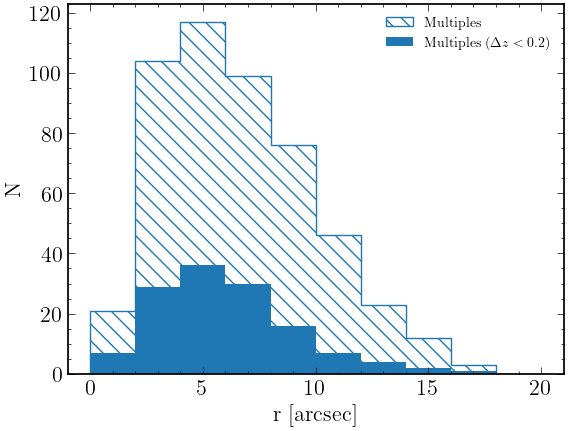

In [849]:
n_bins = 10
r_range = (0,20)

fig, ax = plt.subplots()
ax.hist(herschel_vla_cc_offset_multiples, bins=n_bins, range=r_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.hist(herschel_vla_cc_offset_close_multiples, bins=n_bins, range=r_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

In [1036]:
herschel_vla_cc_distance_close_multiples_lists = [herschel_vla_close_multiples[it].counterpart_counterpart_distance() for it in range(len(herschel_vla_close_multiples))]
herschel_vla_cc_distance_close_multiples = list(chain.from_iterable(herschel_vla_cc_distance_close_multiples_lists))

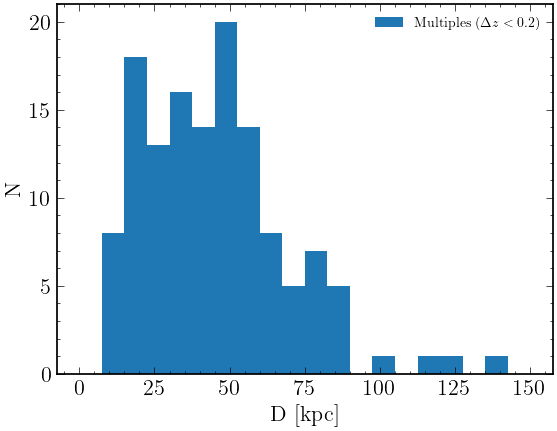

In [1042]:
n_bins = 20
d_range = (0,150)

fig, ax = plt.subplots()
ax.hist(herschel_vla_cc_distance_close_multiples, bins=n_bins, range=d_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'D [kpc]')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

#### Counterpart-Counterpart Flux Differences

In [673]:
herschel_vla_cc_fluxdiff_multiples_lists = [herschel_vla_multiples[it].counterpart_counterpart_flux_difference() for it in range(len(herschel_vla_multiples))]
herschel_vla_cc_fluxdiff_multiples = list(chain.from_iterable(herschel_vla_cc_fluxdiff_multiples_lists))

In [904]:
herschel_vla_cc_fluxdiff_close_multiples_lists = [herschel_vla_close_multiples[it].counterpart_counterpart_flux_difference() for it in range(len(herschel_vla_close_multiples))]
herschel_vla_cc_fluxdiff_close_multiples = list(chain.from_iterable(herschel_vla_cc_fluxdiff_close_multiples_lists))

In [905]:
# A random selection of radio sources as a comparison

N = 1000000
random_flux_differences = []

for _ in range(N):
    rand_obj_1, rand_obj_2 = random.sample(vla_objects, 2)
    rand_flux_diff = abs(rand_obj_1.fluxes.item() - rand_obj_2.fluxes.item())
    if rand_flux_diff > 0:
        random_flux_differences.append(rand_flux_diff)

In [916]:
n_bins = 20
n_bins_random = 100
r_range = (-1,5)
weights = np.full_like(random_flux_differences, (n_bins_random/n_bins)*len(herschel_vla_cc_fluxdiff_multiples)/N)

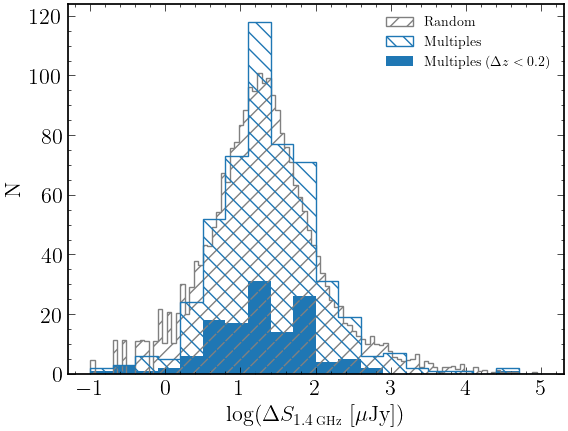

In [917]:
n_bins = 20
logs_range = (-1,5)

fig, ax = plt.subplots()
ax.hist(np.log10(random_flux_differences), bins=n_bins_random, range=logs_range, histtype='step', hatch=r'//', color='grey', label=r'Random', weights=weights)
ax.hist(np.log10(herschel_vla_cc_fluxdiff_multiples), bins=n_bins, range=logs_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.hist(np.log10(herschel_vla_cc_fluxdiff_close_multiples), bins=n_bins, range=logs_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'log($\Delta S_{\small 1.4\,\textrm{GHz}}$ [$\mu$Jy])')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

#### IDs and non-IDs